<a href="https://www.kaggle.com/code/burakaltunda/titanic-ipynb?scriptVersionId=295837789" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

# Load Dataset

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Missing Values

In [4]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train_data.drop("Cabin" ,axis=1 ,inplace=True)

In [6]:
train_data.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


In [7]:
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].mean())
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [8]:
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].mode()[0])
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

<Axes: >

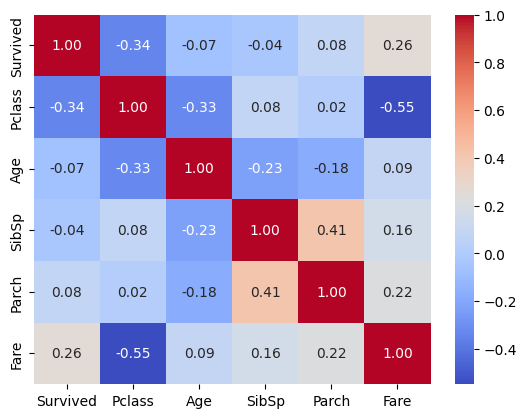

In [9]:
korelasyon_df = train_data[["Survived" , "Pclass", "Age" , "SibSp" , "Parch","Fare"]]
korelasyon = korelasyon_df.corr()
sns.heatmap(korelasyon , annot = True,fmt=".2f",cmap="coolwarm")

In [10]:
train_data.drop("Name" , axis = 1 , inplace = True)
train_data.drop("Ticket" , axis = 1 , inplace = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [11]:
train_data.drop("PassengerId" , axis = 1 , inplace = True)
train_data.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,29.699118,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S
8,1,3,female,27.000000,0,2,11.1333,S
9,1,2,female,14.000000,1,0,30.0708,C


# Outliers

(0.0, 500.0)

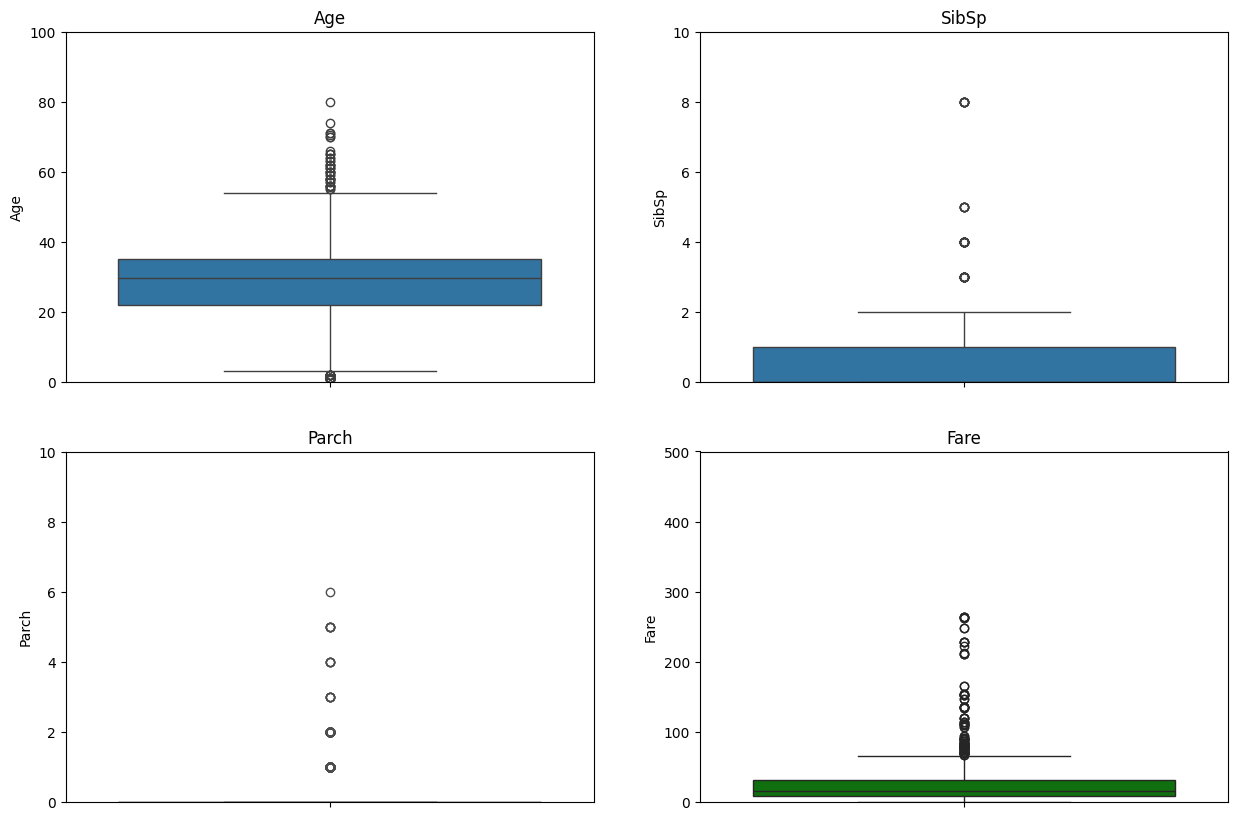

In [12]:
fig , axes = plt.subplots(2,2,figsize=(15,10))
sns.boxplot(ax = axes[0,0] , data = train_data , y="Age")
axes[0,0].set_title("Age")
axes[0,0].set_ylim(0,100)
sns.boxplot(ax = axes[0,1] , data = train_data ,y="SibSp")
axes[0,1].set_title("SibSp")
axes[0,1].set_ylim(0,10)
sns.boxplot(ax=axes[1,0] ,data = train_data , y = "Parch" ,color="red")
axes[1,0].set_title("Parch")
axes[1,0].set_ylim(0,10)
sns.boxplot(ax = axes[1,1] , data = train_data , y="Fare",color = "green")
axes[1,1].set_title("Fare")
axes[1,1].set_ylim(0,500)

In [13]:
train_data["SibSp"].value_counts()
train_data.loc[train_data["SibSp"] > 4 , "SibSp" ] = 5
train_data["Parch"].value_counts()
train_data.loc[train_data["Parch"] > 2 , "Parch"] = 3

### IQR

In [14]:
check_features = ["Age" , "Fare"]
for col in check_features:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    ust_sinir = Q3 + ( 1.5 * IQR )
    alt_sinir = Q1 - ( 1.5 * IQR )

    aykiri_sayisi = len (train_data[(train_data[col] > ust_sinir) | (train_data[col] < alt_sinir)])
    print(f"---{col} Analizi---")
    print(f"Üst Sınır: {ust_sinir} Alt Sınır: {alt_sinir}")
    print(f"Aykırı Yolcu Sayısı: {aykiri_sayisi}")

train_data.loc[train_data["Age" ] > 55 , "Age"] = 55

fare_95 = train_data["Fare"].quantile(0.95)
print(len (train_data[train_data["Fare"] > fare_95] ))

train_data.loc[train_data["Fare"] > fare_95 , "Fare"] = fare_95

---Age Analizi---
Üst Sınır: 54.5 Alt Sınır: 2.5
Aykırı Yolcu Sayısı: 66
---Fare Analizi---
Üst Sınır: 65.6344 Alt Sınır: -26.724
Aykırı Yolcu Sayısı: 116
45


In [15]:
fare_is_zero = len (train_data[train_data["Fare"] == 0])
print(fare_is_zero)
train_data.loc[train_data["Fare"] == 0 , "Fare"] = train_data.groupby("Pclass")["Fare"].transform("median")
train_data.describe()

15


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.369151,0.499439,0.362514,28.190898
std,0.486592,0.836071,12.182609,0.966140,0.715721,29.152251
min,0.000000,1.000000,0.420000,0.000000,0.000000,4.012500
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.500000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,55.000000,5.000000,3.000000,112.079150


# Train Test Split

In [16]:
X = train_data[["Pclass","Age","SibSp","Parch","Fare","Sex","Embarked"]]
y = train_data["Survived"]
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.25 ,random_state=42)

# Encoding

In [17]:
print(train_data.info())
print(train_data.head(20))
print(train_data["Sex"].value_counts())
print(train_data["Embarked"].unique())

X_train["Sex"] = X_train["Sex"].map({"male" :  0 , "female" : 1})
X_test["Sex"] = X_test["Sex"].map({"male":0 , "female" : 1})
 
ohe = OneHotEncoder(sparse_output = False , drop = "first")

emb_encoded_X_train = ohe.fit_transform(X_train[["Embarked"]])
emb_encoded_X_test = ohe.transform(X_test[["Embarked"]])

emb_df_X_train = pd.DataFrame (emb_encoded_X_train  , columns = ohe.get_feature_names_out(["Embarked"]) ,index = X_train.index)
emb_df_X_test = pd.DataFrame(emb_encoded_X_test , columns = ohe.get_feature_names_out(["Embarked"]),index = X_test.index) 

X_train = pd.concat([X_train.drop("Embarked" , axis = 1), emb_df_X_train],axis=1)
X_test = pd.concat([X_test.drop("Embarked" , axis = 1) , emb_df_X_test] , axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
None
    Survived  Pclass     Sex        Age  SibSp  Parch     Fare Embarked
0          0       3    male  22.000000      1      0   7.2500        S
1          1       1  female  38.000000      1      0  71.2833        C
2          1       3  female  26.000000      0      0   7.9250        S
3          1       1  female  35.000000      1      0  53.1000        S
4          0       3    male  35.000000      0      0   8.0500        S
5     

# Random Forest Model

In [18]:
rf_model = RandomForestClassifier(n_estimators = 100 , max_depth = 5 , random_state=42)
rf_model.fit(X_train , y_train)

y_pred = rf_model.predict(X_test)

# Evaluation

In [19]:
acc = accuracy_score(y_test , y_pred)
cm = confusion_matrix(y_test , y_pred)
cr = classification_report (y_test , y_pred)
print(f"Accuracy: {acc}")
print("CM:")
print(cm)
print("CR:")
print(cr)

Accuracy: 0.8161434977578476
CM:
[[121  13]
 [ 28  61]]
CR:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       134
           1       0.82      0.69      0.75        89

    accuracy                           0.82       223
   macro avg       0.82      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



In [20]:
train_acc = rf_model.score(X_train  ,y_train)
test_acc  = rf_model.score ( X_test , y_test)
print("Train Acc")
print(train_acc)
print("Test Acc")
print(test_acc)

Train Acc
0.8502994011976048
Test Acc
0.8161434977578476


# Test Dataset Preprocessing

In [21]:
test_data.drop("Cabin" , axis = 1 , inplace = True)
test_data["Age"] = test_data["Age"].fillna(test_data["Age"].mean())
test_data["Embarked"] = test_data["Embarked"].fillna(test_data["Embarked"].mode()[0])
test_data.drop("Name",axis = 1 , inplace = True)
test_data.drop("Ticket",axis = 1 , inplace = True)
pess_id = test_data["PassengerId"]
test_data.drop("PassengerId" , axis = 1 , inplace = True)
test_data.loc[test_data["SibSp"] > 4 ,"SibSp"] = 5
test_data.loc[test_data["Parch"] > 2 , "Parch"] = 3
test_data.loc[test_data["Age"] > 55 , "Age"] = 55 
test_data["Fare"] = test_data["Fare"].fillna(test_data["Fare"].median())
test_data.loc[test_data["Fare"] > fare_95,"Fare"] = fare_95
test_data.loc[test_data["Fare"] == 0 , "Fare"] = test_data.groupby("Pclass")["Fare"].transform("median")
test_data["Sex"] = test_data["Sex"].map({"male": 0 , "female" : 1})
emb_encoded_test = ohe.transform(test_data[["Embarked"]])
emb_df_test = pd.DataFrame(emb_encoded_test , columns = ohe.get_feature_names_out(["Embarked"]))

test_data = pd.concat([test_data.drop("Embarked" , axis = 1 ) , emb_df_test ] , axis = 1)

print(test_data.isnull().sum())
print(test_data.head(20))


Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_Q    0
Embarked_S    0
dtype: int64
    Pclass  Sex       Age  SibSp  Parch     Fare  Embarked_Q  Embarked_S
0        3    0  34.50000      0      0   7.8292         1.0         0.0
1        3    1  47.00000      1      0   7.0000         0.0         1.0
2        2    0  55.00000      0      0   9.6875         1.0         0.0
3        3    0  27.00000      0      0   8.6625         0.0         1.0
4        3    1  22.00000      1      1  12.2875         0.0         1.0
5        3    0  14.00000      0      0   9.2250         0.0         1.0
6        3    1  30.00000      0      0   7.6292         1.0         0.0
7        2    0  26.00000      1      1  29.0000         0.0         1.0
8        3    1  18.00000      0      0   7.2292         0.0         0.0
9        3    0  21.00000      2      0  24.1500         0.0         1.0
10       3    0  30.27259      0      0   7.8958        

# Final Predictions

In [22]:
model_columns = rf_model.feature_names_in_
X_test_final = test_data[model_columns]
final_predictions = rf_model.predict(X_test_final)

submission = pd.DataFrame({
    "PassengerId" : pess_id ,
    "Survived" : final_predictions
})

submission.to_csv("submission.csv" , index=False)